<a href="https://colab.research.google.com/github/mirtorande/muffin-vs-chihuahua/blob/main/MuffinsChihuahuas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [80]:
! pip install -qq wandb
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
import random

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [2]:
# Define a config dictionary object
configs = dict(
    image_size = 64,
    batch_size= 32,
    init_learning_rate = 1e-3,
    epochs = 50,
    dropout = 0.1,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['acc'],
)

## Load the data: the Muffins vs Chihuahuas dataset

### Data download


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = "/content/drive/My Drive/Datasets/archive"

### Filter out the corrupted images

In [5]:
"""num_skipped = 0
for folder_name in ('test/chihuahua', 'train/chihuahua', 'test/muffin', 'train/muffin'):
    folder_path = os.path.join(dataset_path, folder_name)
    for fname in tqdm(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)"""


'num_skipped = 0\nfor folder_name in (\'test/chihuahua\', \'train/chihuahua\', \'test/muffin\', \'train/muffin\'):\n    folder_path = os.path.join(dataset_path, folder_name)\n    for fname in tqdm(os.listdir(folder_path)):\n        fpath = os.path.join(folder_path, fname)\n        try:\n            fobj = open(fpath, "rb")\n            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)\n        finally:\n            fobj.close()\n\n        if not is_jfif:\n            num_skipped += 1\n            # Delete corrupted image\n            os.remove(fpath)\n\nprint("Deleted %d images" % num_skipped)'

### Generate a Dataset

In [6]:
def load_datasets(config, use_val=True):
  """
  Loads Training and Test datasets
  """
  image_size = (config['image_size'], config['image_size']) # (224, 224) originally
  batch_size = config['batch_size']

  if use_val:
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + '/train',
        image_size=image_size,
        batch_size=batch_size,
        validation_split = 0.2,
        subset='both',
        shuffle=True,
        seed=1337
    )
  else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + '/train',
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True,
        seed=1337
    )
    val_ds = None

  test_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_path + '/test',
      image_size=image_size,
      batch_size=batch_size,
      shuffle=False
  )
  return train_ds, val_ds, test_ds

## Visualize the data

In [7]:
def print_class_counts(dataset):
  n_muf=0
  n_chi = 0
  for images, labels in tqdm(dataset):
    for label in labels:
      if label == 0:
        n_chi += 1
      else:
        n_muf += 1

  print(n_muf, n_chi)

In [99]:
def show_sample_figures(images, labels):
  plt.figure(figsize=(10, 10))

  for cell in range(9):
      i = random.randint(0, len(labels)-1)
      ax = plt.subplot(3, 3, cell + 1)
      plt.imshow(images[i]/255)
      plt.title(int(labels[i]))
      plt.axis("off")

## Using image data augmentation

In [9]:
def augment_dataset(dataset, show_preview=False):
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
      ]
  )

  # Show augmentation preview
  if show_preview:
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[1].numpy().astype("uint8"))
            plt.axis("off")

  # Apply `data_augmentation` to the training images.
  dataset = dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
  )

  return dataset

In [10]:
def prefetch_datasets(*args):
  # Prefetching samples in GPU memory helps maximize GPU utilization.
  for i in range(len(args)):
    args[i] = args[i].prefetch(tf.data.AUTOTUNE)
  return args

# Build the model

In [75]:
def make_model(config, input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [128]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(256, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  x = layers.Dropout(config['dropout'])(x)
  outputs = layers.Dense(units, activation=activation)(x)

  return keras.Model(inputs, outputs)

# Train the model

In [56]:
def train_model(config, train_ds, test_ds):
  model = make_model(config, input_shape=(config.image_size, config.image_size) + (3,), num_classes=2)
  keras.utils.plot_model(model, show_shapes=True)

  epochs = config.epochs

  model.compile(
      optimizer=keras.optimizers.Adam(config.init_learning_rate),
      loss=config.loss_fn,
      metrics=["accuracy"],
  )

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, start_from_epoch=5), WandbMetricsLogger(log_freq=2)]

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=test_ds,
  )
  return history

# Objective

In [13]:
def objective(config):
  train, val, _ = load_datasets(config)
  print_class_counts(train)
  show_sample_figures(train)
  train = augment_dataset(train, show_preview=True)
  train, val = prefetch_datasets(train, val)
  history = train_model(config, train, val)
  return max(history.history['val_accuracy'])

In [123]:
train, _, _ = load_datasets(wandb.config, use_val=False)
train = augment_dataset(train, show_preview=False)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [125]:
train.unbatch()

train_x = []
train_y = []
for image, label in train.map(lambda x, y: (x, y)):
    train_x.append(image)
    train_y.append(label)

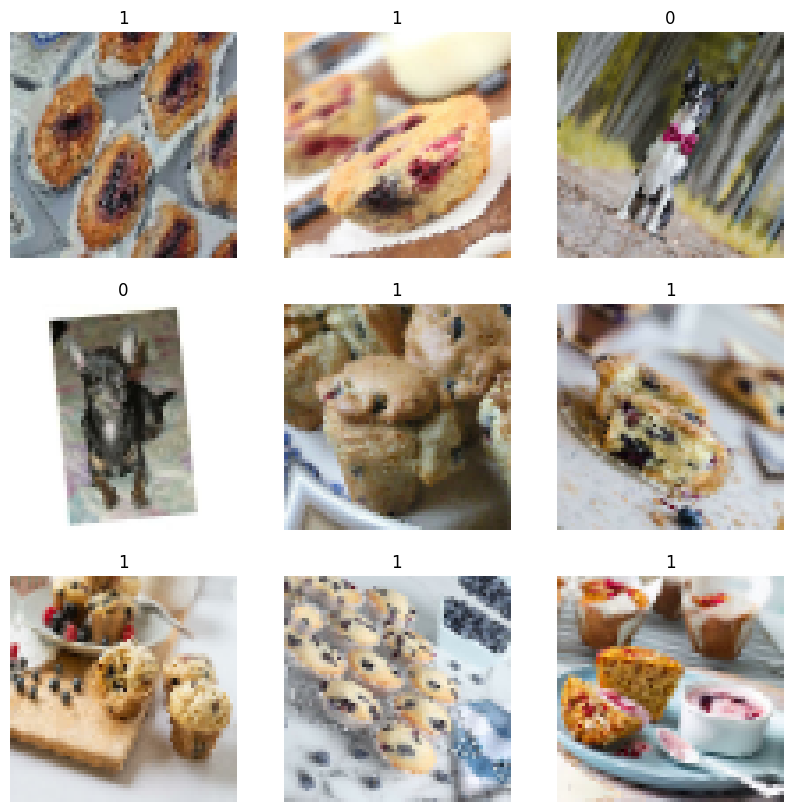

In [119]:
show_sample_figures(train_x, train_y)

In [135]:
def objective_5fold(config):
  train, _, _ = load_datasets(config, use_val=False)
  #print_class_counts(train)
  #show_sample_figures(train)
  train = augment_dataset(train, show_preview=False)

  #TODO: trovare una versione più veloce
  train_unb = train.unbatch()

  train_x = []
  train_y = []
  for images, labels in train_unb.map(lambda x, y: (x, y)):
    train_x.append(images)
    train_y.append(labels)
  train_x = np.array(train_x)
  train_y = np.array(train_y)

  accuracies = []

  for train_indexes, val_indexes in StratifiedKFold(n_splits=5).split(train_x, train_y):

    fold_train_x = []
    fold_train_y = []
    for i in train_indexes:
      fold_train_x.append(train_x[i])
      fold_train_y.append(train_y[i])

    fold_val_x = []
    fold_val_y = []
    for i in val_indexes:
      fold_val_x.append(train_x[i])
      fold_val_y.append(train_y[i])

    model = make_model(config, input_shape=(config.image_size, config.image_size) + (3,), num_classes=2)

    epochs = config.epochs

    model.compile(
        optimizer=keras.optimizers.Adam(config.init_learning_rate),
        loss=config.loss_fn,
        metrics=["accuracy"],
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, start_from_epoch=15), WandbMetricsLogger(log_freq=2)]

    history = model.fit(
        np.array(fold_train_x), np.array(fold_train_y),
        epochs=epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        validation_data=(np.array(fold_val_x), np.array(fold_val_y)),
    )
    accuracies.append(max(history.history['val_accuracy']))

    # training preds
    for i in range(10):
      img = fold_train_x[i]
      predictions = model.predict(np.reshape(img,(1,64,64,3)))
      score = float(predictions[0])
      ground_truth = fold_train_y[i]
      print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin. and it should be {ground_truth}")
      plt.imshow(img/255)
      plt.title(int(ground_truth))
      plt.axis("off")
      plt.show()

    # validation preds
    for i in range(10):
      img = fold_val_x[i]
      predictions = model.predict(np.reshape(img,(1,64,64,3)))
      score = float(predictions[0])
      ground_truth = fold_val_y[i]
      print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin. and it should be {ground_truth}")
      plt.imshow(img/255)
      plt.title(int(ground_truth))
      plt.axis("off")
      plt.show()

  return np.mean(accuracies)

In [ ]:
wandb.init(project='MuffinChihuahuas', config=configs)
val_accuracy = objective_5fold(wandb.config)
val_accuracy

In [ ]:
def main():
    wandb.init()
    val_accuracy = objective_5fold(wandb.config)
    wandb.log({'val_accuracy': val_accuracy})

# 2: Define the search space
sweep_configuration = {
    'method': 'bayes',
    'metric':
    {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters':
    {
        'init_learning_rate': {
            'distribution': 'log_uniform_values', 'max': 1e-2, 'min': 1e-5
        },
        'batch_size': {
          # integers between 32 and 1024
          # with evenly-distributed logarithms
          'distribution': 'q_log_uniform_values',
          'q': 32,
          'min': 32,
          'max': 1024,
        },
        'dropout': {
          'values': [0.2, 0.3, 0.4, 0.5, 0.7]
        },
    }
}
sweep_configuration['parameters'].update({attribute:{'value':value} for attribute, value in configs.items()})

# 3: Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project='MuffinChihuahuas'
)

wandb.agent(sweep_id, function=main, count=10)

Getting best values

In [ ]:
api = wandb.Api()
sweep = api.sweep(f"minigi/MuffinChihuahuas/sweeps/8mvl2ozv")

# Get best run parameters
best_run = sweep.best_run(order='val_accuracy')
best_parameters = best_run.config
print(best_parameters)

In [ ]:
best_run.summary

In [28]:
#wandb.init(project='MuffinChihuahua', config=best_parameters)
train, _, _ = load_datasets(wandb.config, use_val=False)
train = augment_dataset(train, show_preview=False)
print(len(train))
#train = train.unbatch()
train_x = np.concatenate([x for x, y in train], axis=0)
train_x.shape

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
148


(4733, 64, 64, 3)

In [25]:
train_x[0].shape

(64, 64, 3)

In [30]:
train_x = np.concatenate([x for x, y in train], axis=0)
train_y = np.concatenate([y for x, y in train], axis=0)
train_y.shape

(4733,)

In [ ]:
for train_indexes, val_indexes in StratifiedKFold(n_splits=5).split(train_x, train_y):
  print("training", train_x[train_indexes].shape, train_y[train_indexes].shape)
  print(np.bincount(train_y[train_indexes]))
  print("validation", train_x[val_indexes].shape, train_y[val_indexes].shape)
  print(np.bincount(train_y[val_indexes]))

In [33]:
#train_ds, _, _ = load_datasets(wandb.config, use_val=False)

train_batched_x = list(train_ds.map(lambda x, y: x))
train_x = []
for batch in train_batched_x:
    for element in batch:
        train_x.append(element)
train_batched_y = list(train_ds.map(lambda x, y: y))
train_y = []
for batch in train_batched_y:
    for element in batch:
        train_y.append(element)

print(len(train_x), len(train_y))

4733 4733


In [38]:
int(train_y[1])

1

In [ ]:
! wandb sweep --stop minigi/MuffinChihuahuas/8mvl2ozv

In [ ]:
wandb.init(project='MuffinChihuahua', config=best_parameters)
print(wandb.config)
finale_value = objective_5fold(wandb.config)
print(final_value)
wandb.finish()

# Run inference on new data

In [ ]:
"""def keralize_img(path):
  img = keras.utils.load_img(
    path, target_size=configs.image_size
  )
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  return img_array

chihuahua_img = keralize_img(dataset_path + '/test/muffin/img_0_67.jpg')
muffin_img = keralize_img(dataset_path + '/test/chihuahua/img_0_1107.jpg')

def predict(img):
  model.load_weights("/content/save_at_7.keras")
  predictions = model.predict(img)
  score = float(predictions[0])
  print(f"This image is {100 * (1 - score):.2f}% chihuahua and {100 * score:.2f}% muffin.")

predict(chihuahua_img)
predict(muffin_img)"""